In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [ ]:
%load_ext autoreload
%autoreload 2

In [421]:
use_neptune = False

In [422]:
import neptune
import tensorflow as tf

import io
import cirq
import numpy as np
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [431]:
generator_layers = 3
data_bus_size = 5
rank = 4

In [439]:
real_phase = True
generic_generator = False
zxz = False
all_gates_parametrized = False

In [440]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [441]:
builder = PhaseCircuitBuilder(all_gates_parametrized=False)
real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)

In [442]:
pauli_strings, qubit_to_string_index = quwgans_circuits.get_discriminator(real)

In [443]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [444]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                         │
(0, 1): ───────X───Z───Ry(theta_r)───H───X───H───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                               │                                       │
(0, 2): ─────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                               │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                               │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [445]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───H───@────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                        │
(0, 1): ───────X───Z───Ry(theta0)───H───X───H───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                             │                                     │
(0, 2): ────────────────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                         │                                     │
(0, 3): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                      │                                      │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───

In [446]:
g_values = [-1,0]
real_values_provider = get_g_parameters_provider()

In [447]:
opt = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [448]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  rank=rank,
                  use_neptune=use_neptune)

In [449]:
epochs = 5
gen_iteration = 1
snapshot_interval_epochs = 2

In [450]:
if use_neptune:
    neptune.init(project_qualified_name='wiktor.jurasz/thesis-em', api_token=neptun_token)
    neptun_params = {
        'generator_layers': generator_layers,
        'size':  data_bus_size,
        'rank': rank,
        'real_phase': real_phase,
        'generic_generator': generic_generator,
        'zxz': zxz,
        'all_gates_parametrized': all_gates_parametrized,
        'g_values': g_values,
        'gen_iteration': gen_iteration,
        'epochs': epochs
    }
    neptune.create_experiment(name=None, description=None, params=neptun_params)
    neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
    neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

<Figure size 432x288 with 0 Axes>

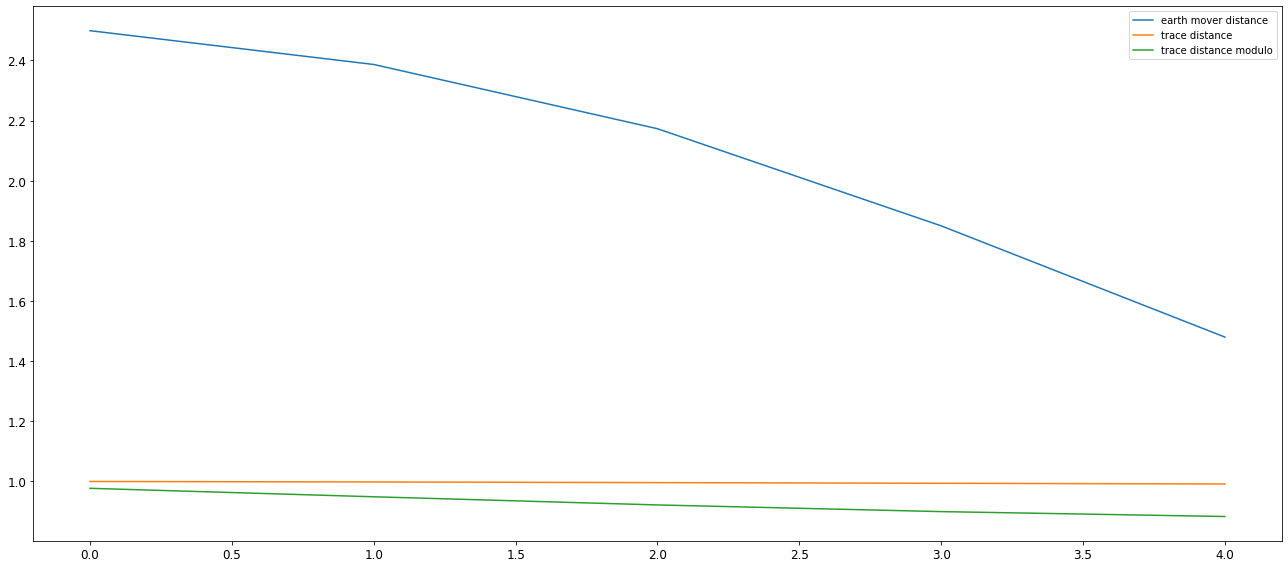

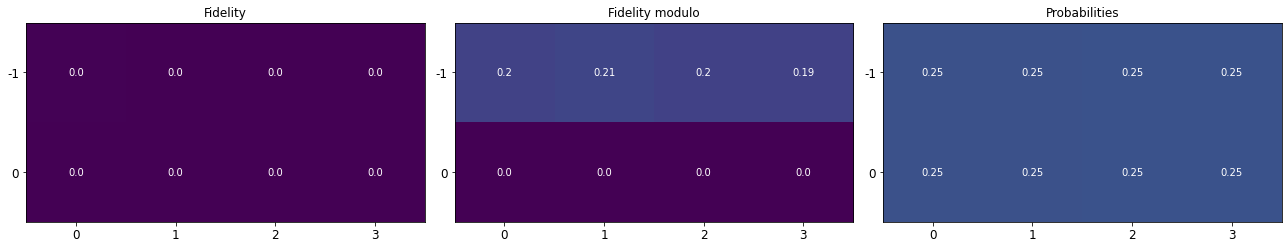

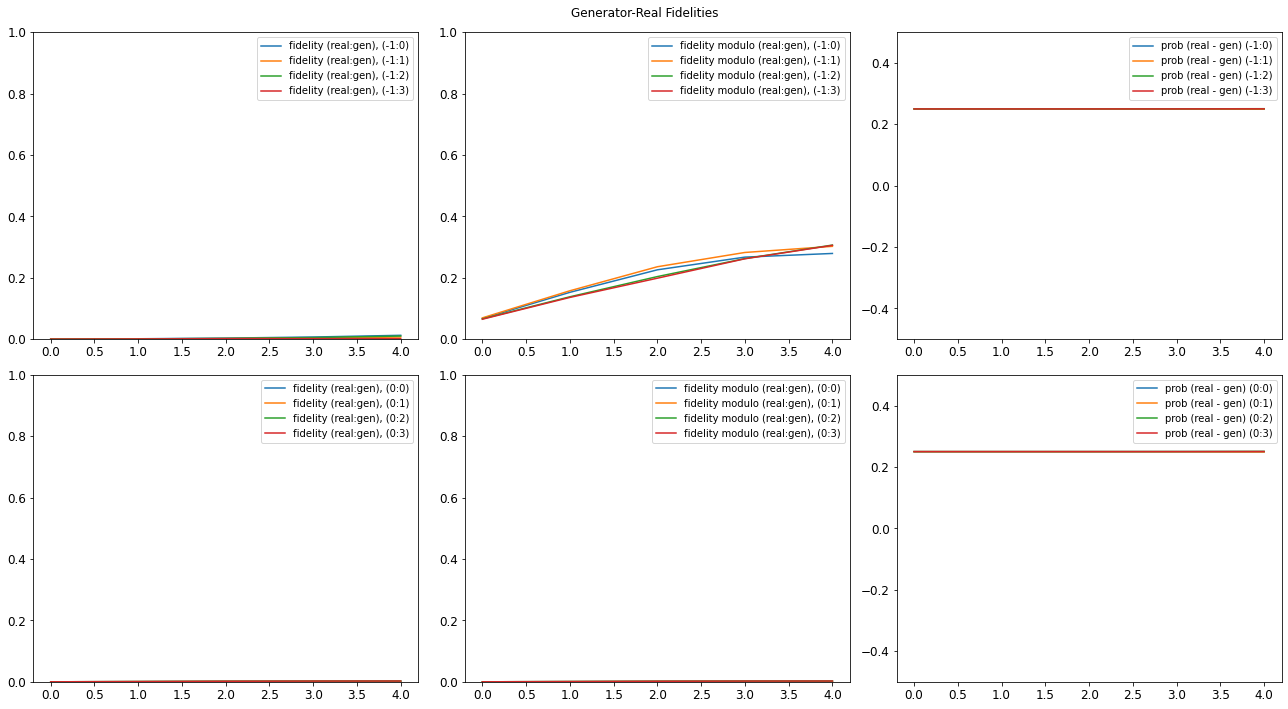

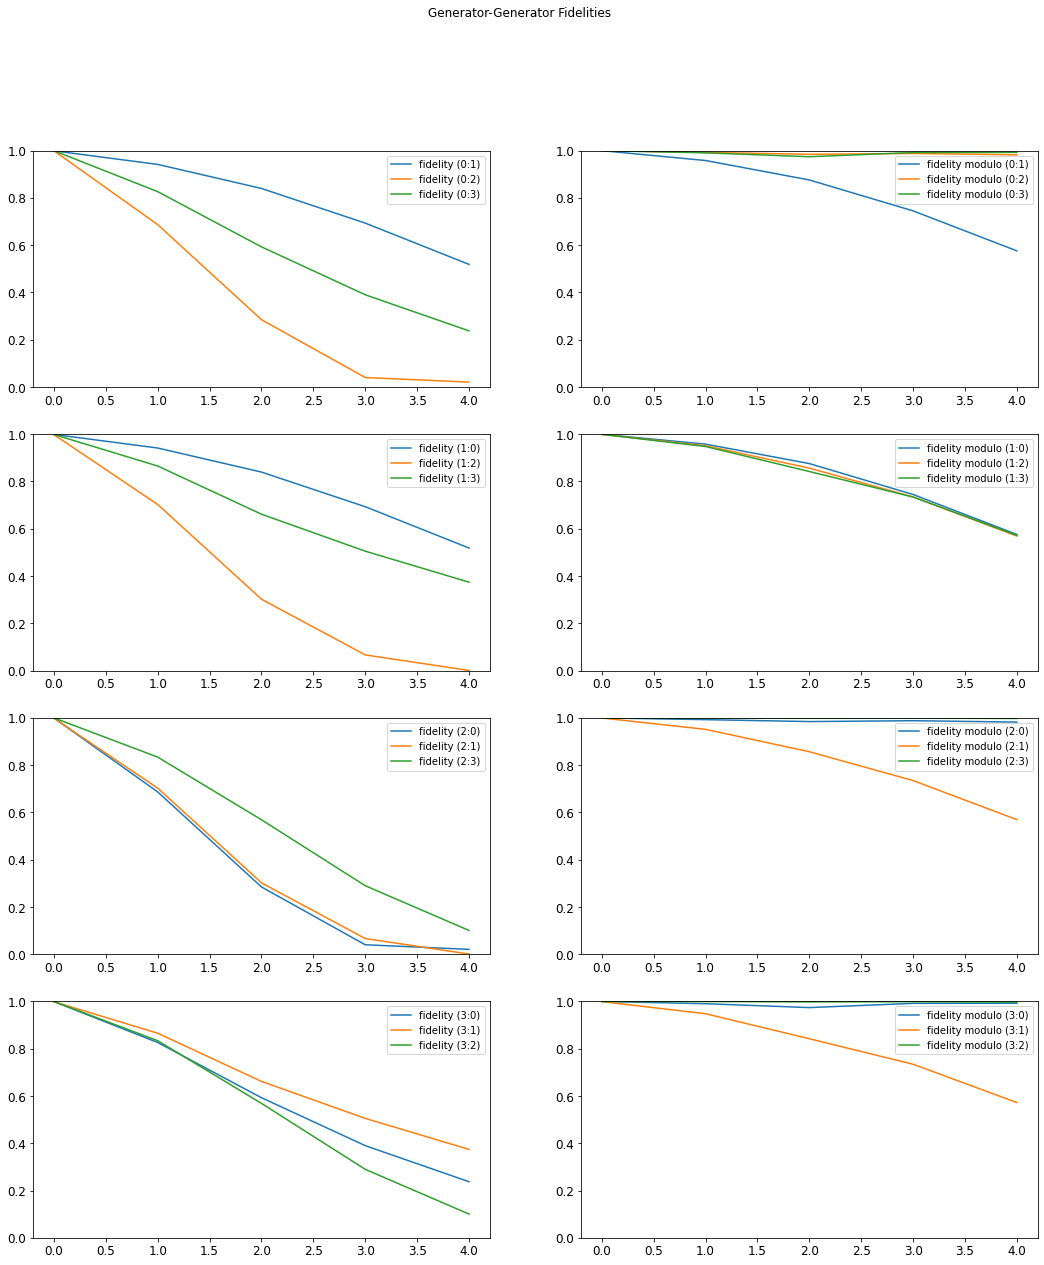

----------------------------------------------------
Epoch 4:  EM distance = 1.480243443062225, trace distance = 0.9916441984411488, abs trace distance = 0.8835086239725428
h=Z((0, 2)), w=0.4999999998607215, e=0.5613497495651245
h=Z((0, 2)), w=0.4999999998028394, e=0.5613497495651245
h=X((0, 3)), w=0.4999999996944557, e=0.3556537628173828
h=X((0, 0))*X((0, 1)), w=0.9999999985385988, e=0.7410668134689331
-------------------------------------
----------- TRAINING DONE -----------


In [451]:
json_result = trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

In [ ]:
def get_all_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator,
                                    g, 
                                    size):
    generated = gen_evaluator.get_all_states_from_params()
    real = real_evaluator.get_all_states_from_params()
    
    return generated, real, 

In [ ]:
gen_evaluator = trainer.gen_evaluator
real_evaluator = trainer.real_evaluator

In [ ]:
trainer.get_fidelty_for_real()

In [420]:
gen_evaluator.get_all_states_from_params()

[(1.0,
  0,
  array([-0.18042792+0.j, -0.20451955+0.j, -0.18201526+0.j,  0.16252919+0.j,
          0.15139015+0.j,  0.17160453+0.j, -0.18883148+0.j,  0.16861567+0.j,
          0.1690605 +0.j,  0.19163431+0.j,  0.1705478 +0.j, -0.15228942+0.j,
          0.16119745+0.j,  0.18272136+0.j, -0.20106426+0.j,  0.17953886+0.j,
          0.18015143+0.j,  0.20420618+0.j,  0.1817363 +0.j, -0.16228011+0.j,
         -0.15115815+0.j, -0.17134155+0.j,  0.18854207+0.j, -0.16835727+0.j,
         -0.16931996+0.j, -0.19192843+0.j, -0.17080958+0.j,  0.15252316+0.j,
         -0.16144489+0.j, -0.18300183+0.j,  0.20137289+0.j, -0.17981446+0.j],
        dtype=complex64),
  array([0.18042792, 0.20451955, 0.18201526, 0.16252919, 0.15139015,
         0.17160453, 0.18883148, 0.16861567, 0.1690605 , 0.19163431,
         0.1705478 , 0.15228942, 0.16119745, 0.18272136, 0.20106426,
         0.17953886, 0.18015143, 0.20420618, 0.1817363 , 0.16228011,
         0.15115815, 0.17134155, 0.18854207, 0.16835727, 0.16931996,


In [ ]:
real_evaluator.get_all_states_from_params()

In [ ]:
if use_neptune:
    neptune.stop()